In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import mannwhitneyu

import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

In [2]:
#1. import dataset

titanic = pd.read_csv('titanic_train.csv')
titanic.head()

#sibsp = jml bawa sibling/spouse
#parch = parent/children
#fare = harga tiket
#embark = keberangkatan

C:\Users\asus\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


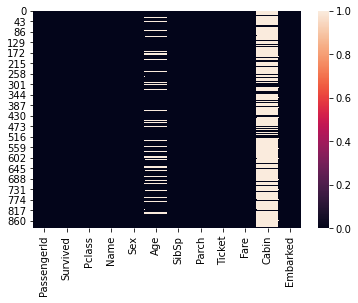

In [3]:
#membuat heatplot untuk melihat data yg hilang

sns.heatmap(titanic.isna())

plt.show()

In [4]:
#melihat persentase null

titanic.isna().sum()/len(titanic)*100

#diatas 50 yg hilang == bisa dihapus
#dibawah 50 yg hilang == bisa diimpute

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [5]:
#Semisal cabin mau diakalin, bisa diimput dengan mengganti Nan menjadi none.
#cek valuecount include null

#tapi disini kita apus cabinnya
titanic['Cabin'].value_counts(dropna = False)

NaN            687
G6               4
B96 B98          4
C23 C25 C27      4
C22 C26          3
              ... 
D19              1
E58              1
A6               1
B38              1
B73              1
Name: Cabin, Length: 148, dtype: int64

In [6]:
#biar nyaman,  nama columnnya kita lower

titanic.columns = titanic.columns.str.lower()
titanic.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [7]:
#apus kolom cabin, passengerid, ticket

titanic.drop(['cabin', 'passengerid', 'ticket'], axis = 1, inplace = True)
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


## __FEATURE ENGINEERING__
- Mengotak-atik feature

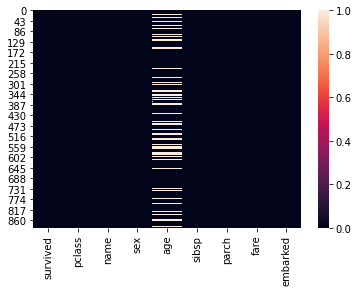

In [8]:
sns.heatmap(titanic.isna())

plt.show()

> ### __AGE__

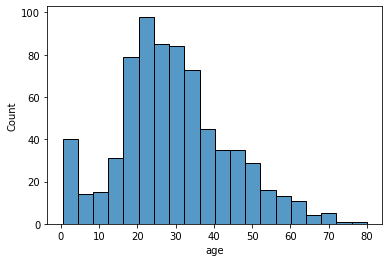

In [9]:
##normality test dengan plot

sns.histplot(titanic.age)

plt.show()

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

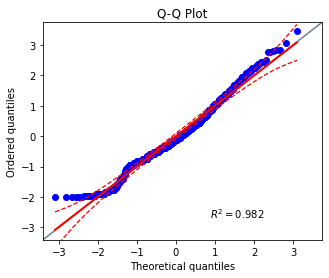

In [10]:
#normality test dengan qqplot

pg.qqplot(titanic.age, dist = 'norm')

#hasilnya cukup normal distribution

> ### __EMBARKED__

In [11]:
titanic.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [12]:
titanic[titanic['embarked'].isna() ==  True]

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


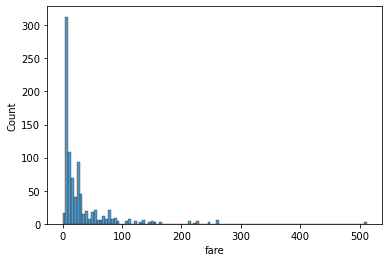

In [13]:
#membuat plot ...

sns.histplot(titanic.fare)
plt.show()

In [14]:
#mencari rata2 harga berdasarkan kelas dan tempat keberangkatan

pd.crosstab(index = titanic.embarked, columns = titanic.pclass, values = titanic.fare, aggfunc = np.mean)

pclass,1,2,3
embarked,,,
C,104.718529,25.358335,11.214083
Q,90.000000,12.350000,11.183393
S,70.364862,20.327439,14.644083


In [15]:
#mencari jumlah perempuan berdasarkan keberangkatan

pd.crosstab(index = titanic.embarked, columns = titanic.sex, normalize = 1)

#dari semua yg female yg ditatnic, kebanyaan berangkat dari S

sex,female,male
embarked,,
C,0.233974,0.164645
Q,0.115385,0.071057
S,0.650641,0.764298


> ### __NAME__

In [16]:
#mengambil gelar dari nama

#titanic['name'].str.split(',')
# titanic['name'].str.split(',').str[1]
# titanic['name'].str.split(',').str[1].str.split('.')
titanic['title'] = titanic['name'].str.split(',').str[1].str.split('.').str[0]

titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [17]:
#mengecek nunique dari title

titanic.title.unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

In [18]:
#menghapus kolom name (harus diapus karena string dan tidak akan dinumerikal)

titanic.drop(['name'], axis = 1, inplace = True)

## __EDA__

- EDA lebih ke target variable

In [19]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


> ### __SURVIVED__

<AxesSubplot:ylabel='survived'>

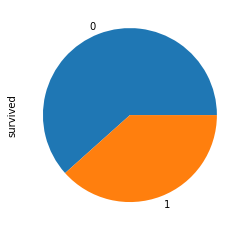

In [20]:
titanic.survived.value_counts(normalize = True).plot(kind = 'pie')

> ### __SURVIVED & FARE__

sns.histplot(titanic[titanic['survived'] == 0][fare], label = 'Not Survived')
sns.histplot(titanic[titanic['survived'] == 1][fare], label = 'Survived')
plt.legend()
plt.plot()

> ### __SURVIVED & SEX__

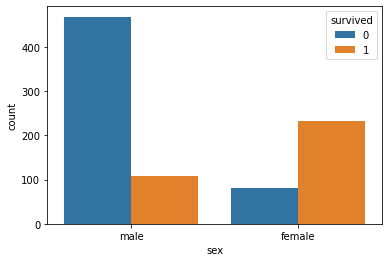

In [21]:
sns.countplot(x ='sex', hue = 'survived', data = titanic)
plt.show()


#Yang female lebih kecil .....

In [22]:
#menghitung ratio selamat berdasarkan sex

pd.crosstab(index = titanic['sex'], columns = titanic['survived'], normalize = 0)


#female kecenderungan selamat sebanyak 74%, sedangkan lelaki 18%

survived,0,1
sex,,
female,0.257962,0.742038
male,0.811092,0.188908


C:\Users\asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 71.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 48.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


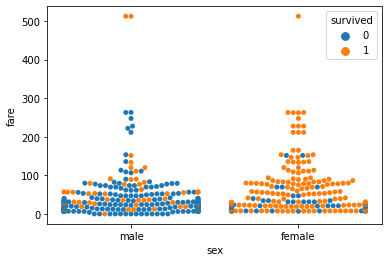

In [23]:
#menghitung ratio selamat berdasarkan sex dan fare

sns.swarmplot(y="fare", x="sex", hue="survived", data=titanic)
plt.show()

> ### __SURVIVED & SIBLINGS__

In [24]:
titanic['sibsp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

<AxesSubplot:xlabel='sibsp'>

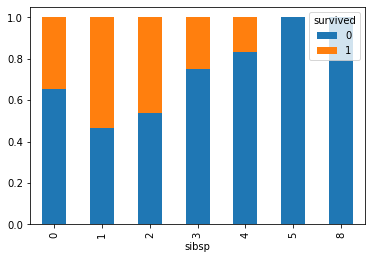

In [25]:
pd.crosstab(titanic['sibsp'], titanic['survived'], normalize = 0).plot(kind = 'bar', stacked = True)

#yg sendirian, cenderung tidak selamat
#jika membawa satu, agak cenderung masih selamat
# diatas 2, cenderung tidak selamat

In [26]:
pd.crosstab(titanic['sibsp'], titanic['survived'], normalize = 0)

survived,0,1
sibsp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


In [27]:
#keluarga yg ber8

titanic[titanic['sibsp'] == 8]

#sekeluarga sama, keberangkatan sama, 

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
159,0,3,male,NaN,8,2,69.55,S,Master
180,0,3,female,NaN,8,2,69.55,S,Miss
201,0,3,male,NaN,8,2,69.55,S,Mr
324,0,3,male,NaN,8,2,69.55,S,Mr
792,0,3,female,NaN,8,2,69.55,S,Miss
846,0,3,male,NaN,8,2,69.55,S,Mr
863,0,3,female,NaN,8,2,69.55,S,Miss


> ### __SURVIVED & EMBARKED__

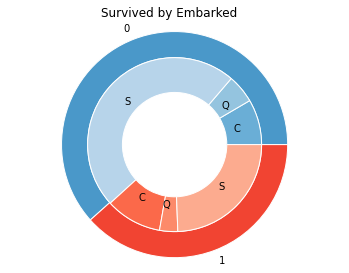

In [28]:
#Membuat donat plot

#a. membuat df baru berdasarkan groupby embarked
by_embarked = titanic.groupby('embarked')['survived'].value_counts().to_frame().rename(columns={'survived': 'freq'}).reset_index().sort_values('survived')

# Make data: I have 2 groups and 3 subgroups
group_names=titanic['survived'].value_counts().index
group_size=titanic['survived'].value_counts()
subgroup_names=by_embarked['embarked']
subgroup_size=by_embarked['freq']
 
# Create colors
a, b, c = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Survived by Embarked')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

In [29]:
#membaca donut plot diatas

pd.crosstab(index = titanic['embarked'], columns = titanic['survived'], normalize = 1)

#dari semua yg selamat, keberangkatan S paling tinggi namun paling tinggi jg yg tidak selamat

survived,0,1
embarked,,
C,0.136612,0.273529
Q,0.085610,0.088235
S,0.777778,0.638235


In [30]:
#melihat jumlah keberangkatan berdasarkan kelas

titanic[titanic['embarked'] == 'S']['pclass'].value_counts()

#kebanyakan orang yg naik dari S, itu kelas 3... mereka tidak selamat, jadi paling tinggi rationya

3    353
2    164
1    127
Name: pclass, dtype: int64

<AxesSubplot:xlabel='fare'>

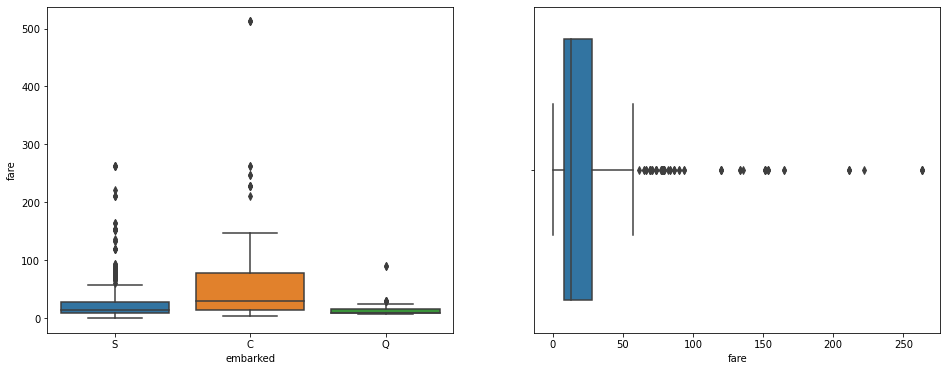

In [31]:
##keberangkatan S, mayoritas tidak selamat
# yg tidak selamat biasanya yg bayar fare nya murah

#jadi kita bikin plot dan hipotesis testing

plt.figure(figsize = (16,6))
plt.subplot(121)
sns.boxplot(x = 'embarked', y = 'fare', data = titanic)

plt.subplot(122)
sns.boxplot(x = titanic[titanic['embarked']== 'S']['fare'])


##BELOM SELESE


#kalo dari plot, kita pakenya non parametrik saoalnya skew === kruskal wallis (versi non parametriknya ttest one way dan bandinginnya bisa 3)
#kalo non parametrik pakenya mannwithneyu (versi nonparametriknya ttest unpaired dan bisa bandinginnya 2)


kalo 3 group gini, ada kruskal wallis (test untuk 2 atau lebih independent sample di satu kolom)

In [32]:
#Mencari hipotesis testing


stats, p = mannwhitneyu(titanic[titanic['embarked'] == 'S']['fare'], titanic[titanic['embarked'] == 'C']['fare'], alternative = 'less' )

if p < 0.05:
    print('Southampton median fare are lest than Cherbourg')
else:
    print('Southampton median fare are equal to Cherbourg')

Southampton median fare are lest than Cherbourg


In [33]:
#Mencari hipotesis testing


stats, p = mannwhitneyu(titanic[titanic['embarked'] == 'S']['fare'], titanic[titanic['embarked'] == 'Q']['fare'], alternative = 'less' )

if p < 0.05:
    print('Southampton median fare are lest than Queenstown')
else:
    print('Southampton median fare are equal to Queenstown')

Southampton median fare are equal to Queenstown


<AxesSubplot:xlabel='embarked'>

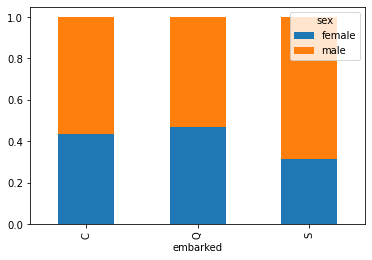

In [34]:
pd.crosstab(index = titanic['embarked'], columns = titanic['sex'], normalize = 0).plot(kind = 'bar', stacked = True)

Analisa dari plot diatas:

- Kalo male, dia berangkat dari S, dan harganya murah === tidak selamatnya tinggi


> ### __SURVIVED & TITLE__

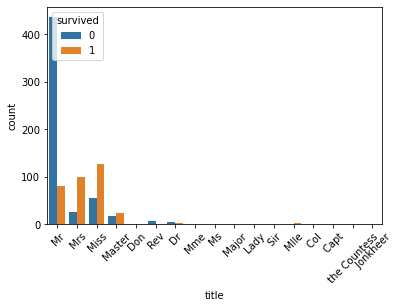

In [35]:
#membuat plot dari title dan survived

sns.countplot(x='title', hue = 'survived', data = titanic)
plt.xticks(rotation = 45)
plt.show()

#untuk title Mr == kecenderungan tidak selamat tinggi

In [36]:
pd.crosstab(index = titanic['title'], columns = titanic['survived'], normalize = 0).sort_values(0, ascending = False)

survived,0,1
title,,
Capt,1.000000,0.000000
Don,1.000000,0.000000
Jonkheer,1.000000,0.000000
Rev,1.000000,0.000000
Mr,0.843327,0.156673
Dr,0.571429,0.428571
Major,0.500000,0.500000
Col,0.500000,0.500000
Master,0.425000,0.575000


In [37]:
## cerita2 tiap eda ditulis di markdown

#### __Skenario__

Impute
- Age impute with mean
- embarked with S (mode)
- name only with title

Encoder:
- sex -> oneHote
- embarked ->  onehot
- title -> binary

Drop:
- pasenger id

- pake roc, karena tidak condong ke salah satu kelas

## __MODELLING__

In [38]:
# Menentukan variabel dependen dan indepnden

X = titanic.drop('survived', axis =1)
y = titanic['survived']

In [39]:
#data splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

> ### __PIPELINE : DTC__

In [40]:
# MEMBUAT PIPELINE

#1. IMPUTE (usahakan tiap data satu kolom)
#a. impute age (num)
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'mean'))
])

#b. impute embarked (cat & onehot)
onehot_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy = 'constant', fill_value = 'S')),
    ('onehot', OneHotEncoder(drop = 'first'))
])

#c. impute tittle (binary)
binary_pipeline = Pipeline([
    ('binary', ce.BinaryEncoder())
])

#2. TRANSFROM
transformer = ColumnTransformer([
    ('Impute_pipe', numerical_pipeline, ['age']),
    ('onehot_pipe', onehot_pipeline, ['sex', 'embarked']),
    ('binary_pipe', binary_pipeline, ['title'])
], remainder = 'passthrough')

#3. MODEL INITIALIZING
dtc = DecisionTreeClassifier(max_depth = 5, random_state = 1912)
smote = SMOTE() #Aagar didalam pipeline bisa lsg melakukan resampling
rfe = RFE(estimator = dtc) #diambil kolum terbaiknya


#4. MEMBUAT PIPELINE BESAR
all_in_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', rfe),
    ('resampling', smote),
    ('clf', dtc)
])

__Noted to me:__
- kalo nambah model, dibikin lagi pipelinenya satu full cell
- kalo knn, nambah standarscaler
- terus fokus disalah satu class atau engga

In [41]:
#untuk...

all_in_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('Impute_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer())]),
                                    ['age']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(fill_value='S',
                                                                   strategy='constant')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex', 'embarked']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['titl

In [42]:
hyperparam_space = {
    'clf__max_depth': [2,3,4,5,6,7],
    'clf__min_samples_split': [4,5,6,7,8,9,10],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,6,7,8]
}

skf = StratifiedKFold(n_splits = 5)

gridsearch = GridSearchCV(all_in_pipeline, hyperparam_space, scoring = 'f1', n_jobs =-1, cv = skf)
gridsearch.fit(X_train_val, y_train_val)

C:\Users\asus\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_pipe',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer())]),
                                                                         ['age']),
                                                                        ('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(fill_value='S',
                                                                                      

In [43]:
#mendapatkan best parameter

gridsearch.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 6,
 'clf__min_samples_split': 7,
 'rfe__n_features_to_select': 7}

In [44]:
#mendapatkan best estimator

gridsearch.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Impute_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer())]),
                                                  ['age']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(fill_value='S',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'embarked']),
                    

In [45]:
#menampilkan cv result

cv_res_df = pd.DataFrame(gridsearch.cv_results_)
cv_res_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.194090,0.068801,0.052170,0.025185,entropy,2,4,None,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.718447,0.713043,0.707071,0.626263,0.743802,0.701725,0.039753,348
1,0.102142,0.013652,0.025984,0.003403,entropy,2,4,5,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.718447,0.713043,0.707071,0.626263,0.757282,0.704421,0.042851,322
2,0.093748,0.006642,0.026384,0.005710,entropy,2,4,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.718447,0.696296,0.707071,0.626263,0.743802,0.698376,0.039361,388
3,0.088950,0.002097,0.022586,0.000800,entropy,2,4,7,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.718447,0.713043,0.707071,0.626263,0.757282,0.704421,0.042851,322
4,0.086751,0.003058,0.027583,0.005950,entropy,2,4,8,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.718447,0.696296,0.707071,0.626263,0.743802,0.698376,0.039361,388


In [46]:
#menampilkan yg rank test score terbaik

cv_res_df[cv_res_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
368,0.10834,0.016369,0.024986,0.004145,gini,6,7,7,"{'clf__criterion': 'gini', 'clf__max_depth': 6...",0.776699,0.747826,0.702128,0.789474,0.773585,0.757942,0.031011,1


## __COMPARE: DEFAULT MODEL & TUNED MODEL__

In [47]:
#model 1:

model_default = all_in_pipeline.fit(X_train_val, y_train_val)
y_pred_default = model_default.predict(X_test)

print(classification_report(y_test, y_pred_default))

C:\Users\asus\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.88      0.76      0.82       110
           1       0.69      0.84      0.76        69

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.81      0.79      0.80       179



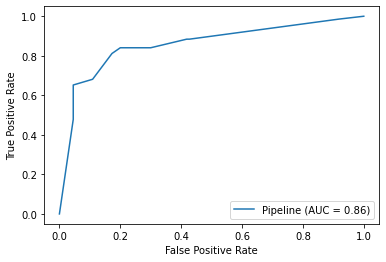

In [48]:
#membuat plot roc model1:

plot_roc_curve(model_default, X_test, y_test)

In [49]:
#model 2: jadi lebih jelek

model_tuned = gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_tuned = model_tuned.predict(X_test)

print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       110
           1       0.83      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



C:\Users\asus\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


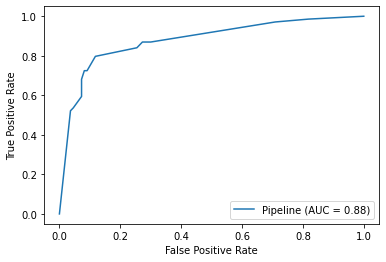

In [50]:
#membuat plot roc model2:

plot_roc_curve(model_tuned, X_test, y_test)

__Jadi yang dipakai adalah model default karena lebih bagus__

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       110
           1       0.65      0.84      0.73        69

    accuracy                           0.77       179
   macro avg       0.76      0.78      0.76       179
weighted avg       0.79      0.77      0.77       179



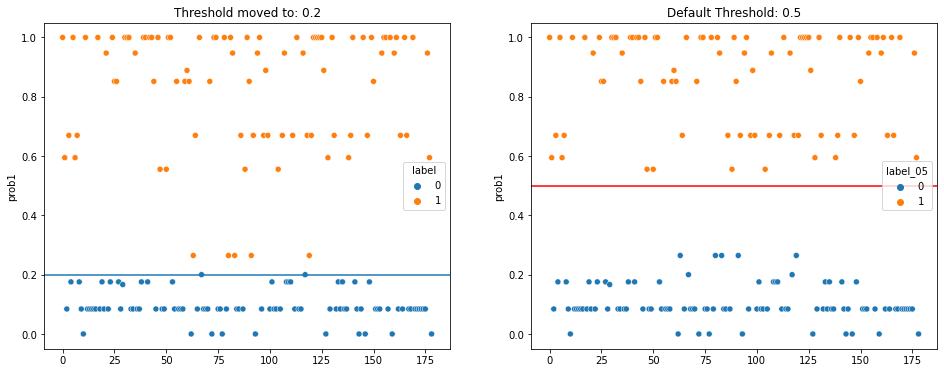

In [56]:
#untuk menampilkan perbanding plot jika thr dipindah

thr_move_to = 0.2
y_pred_thr = np.where(model_default.predict_proba(X_test)[:,1] > thr_move_to, 1, 0)
print(classification_report(y_test, y_pred_thr))

thr_test_df = pd.DataFrame(dict(zip(['label', 'prob1', 'label_05'], [y_pred_thr, model_default.predict_proba(X_test)[:,1], model_default.predict(X_test)])))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title(f'Threshold moved to: {thr_move_to}')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label'])
plt.axhline(thr_move_to)

plt.subplot(122)
plt.title('Default Threshold: 0.5')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label_05'])
plt.axhline(0.5, color='red')

plt.show()

#yg bagus itu fpr thr rendah, tpr tinggi

#...

thr_move_to = 0.2
y_pred_thr = np.where(model_default.predict_proba(X_test[:,1]))

## ROSE AND JACK PREDICT

In [52]:
X_train_val.head()

,pclass,sex,age,sibsp,parch,fare,embarked,title
21,2,male,34.0,0,0,13.0000,S,Mr
172,3,female,1.0,1,1,11.1333,S,Miss
327,2,female,36.0,0,0,13.0000,S,Mrs
713,3,male,29.0,0,0,9.4833,S,Mr
512,1,male,36.0,0,0,26.2875,S,Mr


In [53]:
#mencari harga tiket rose

titanic[titanic['pclass'] == 1]['fare'].mean()

84.15468749999992

In [54]:
#predict rose

    #pclass, sex, age, sib, parch, fare, embarked, title
rose  = [[1, 'female', 17, 1, 1, 85, 'S', 'Miss']]
model_default.predict(pd.DataFrame(rose, columns = X_train_val.columns))

array([1], dtype=int64)

__Rose diprediksi selamat__

In [55]:
#predict jack

    #pclass, sex, age, sib, parch, fare, embarked, title
rose  = [[3, 'male', 20, 0, 0, 0, 'S', 'Mr']]
model_default.predict(pd.DataFrame(rose, columns = X_train_val.columns))

array([0], dtype=int64)

__Jack diprediksi tidak selamat__